# Downloads and Views over time
In this notebook, we summarize download statistics we are collecting for the Zenodo records in our database. The code for this was AI-generated.

In [7]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
def read_file_and_date(filename):
    df = pd.read_csv(filename)
    date = pd.to_datetime(filename.replace("\\", "/").split("/")[-1].replace('.csv', ''), format='%Y%m%d')
    return df, date

In [9]:
folder_path = "../download_statistics/"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Sort the files by date
csv_files.sort()

dfs = []

# Process each file
for filename_old, filename_new in zip(csv_files[:-1], csv_files[1:]):
    # load data and determine timestampe
    df_old, date_old = read_file_and_date(folder_path + filename_old)
    df_new, date_new = read_file_and_date(folder_path + filename_new)
    
    # days difference
    days_diff = (date_new - date_old).days

    # Determine the rows in df_new where "url" values are also in df_old
    df_common = df_new[df_new['url'].isin(df_old['url'])]

    # Set the index to "url" for aligning them
    df_old_indexed = df_old.set_index("url")
    df_common_indexed = df_common.set_index("url")

    # Calculate the difference in the "download" column
    download_difference = df_common_indexed["unique_downloads"] - df_old_indexed["unique_downloads"]
    views_difference = df_common_indexed["unique_views"] - df_old_indexed["unique_views"]
    df_common_indexed = df_common_indexed[["authors"]]
    df_common_indexed["downloads_per_day"] = download_difference / days_diff
    df_common_indexed["views_per_day"] = views_difference / days_diff
    df_common_indexed["timestamp"] = date_new

    dfs.append(df_common_indexed)

df = pd.concat(dfs)
df = df.sort_values(by='downloads_per_day', ascending=False)
df = df.reset_index()
df.head()

,url,authors,downloads_per_day,views_per_day,timestamp
0,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03
1,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",13.142857,4.285714,2024-09-17
2,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",11.857143,12.142857,2024-09-24
3,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",10.857143,7.857143,2024-10-01
4,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",8.857143,11.142857,2024-09-17


## Most downloaded document ever
Document with most downloads per day observed ever:

In [10]:
df["url"][0]

'https://zenodo.org/records/8323588'

## Most viewed document ever

In [11]:
df = df.sort_values(by='views_per_day', ascending=False)
df = df.reset_index()
df.head()

,index,url,authors,downloads_per_day,views_per_day,timestamp
0,2,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",11.857143,12.142857,2024-09-24
1,4,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",8.857143,11.142857,2024-09-17
2,12,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",7.000000,10.142857,2024-09-10
3,8,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",8.058824,9.588235,2024-08-26
4,27,https://zenodo.org/records/12744715,"""Seibold, Heidi""",3.823529,8.529412,2024-08-26


In [12]:
columns = df.columns

## Plotting downloads per day over time

In [13]:
df = df.sort_values(by='downloads_per_day', ascending=False)
df = df.reset_index()
df.head()

,level_0,index,url,authors,downloads_per_day,views_per_day,timestamp
0,22,0,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03
1,23,1,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",13.142857,4.285714,2024-09-17
2,0,2,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",11.857143,12.142857,2024-09-24
3,5,3,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",10.857143,7.857143,2024-10-01
4,1,4,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",8.857143,11.142857,2024-09-17


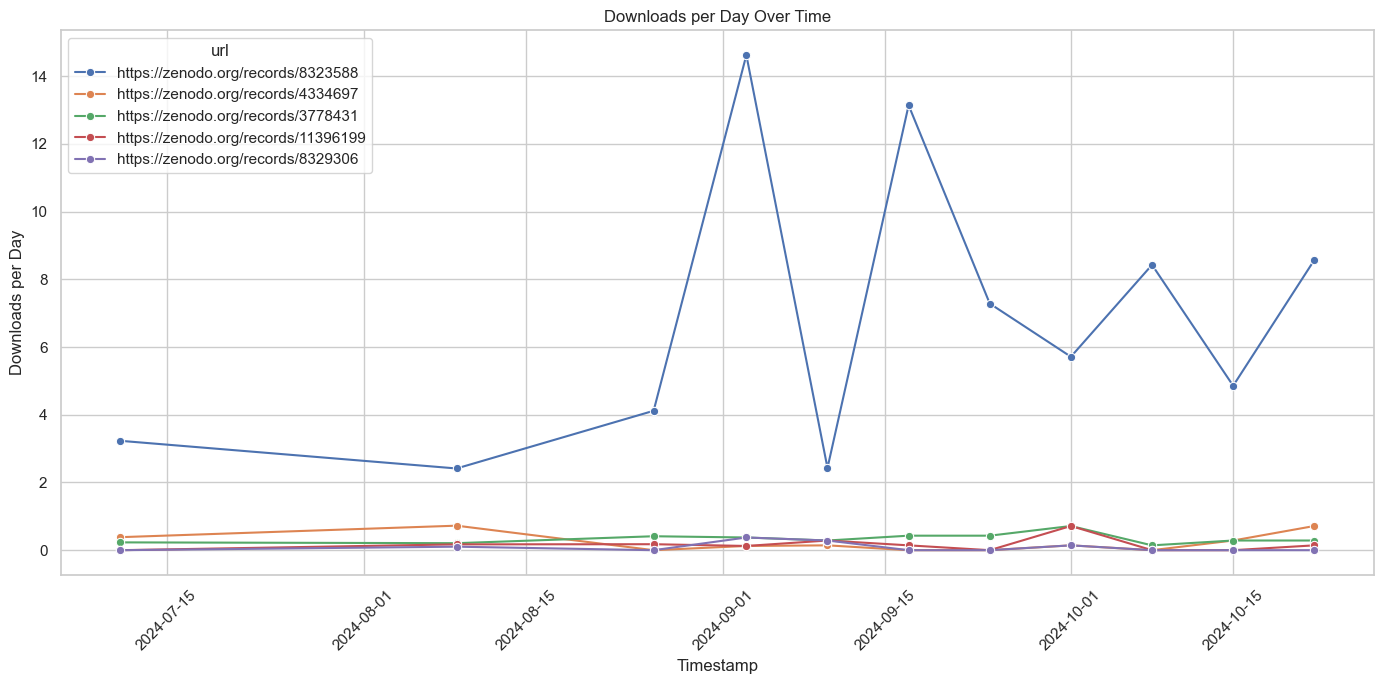

In [21]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Display only the top 5 URLs based on their count
top_labels = df['url'].value_counts().nlargest(5).index

# Filter the DataFrame to include only the top URLs
filtered_df = df[df['url'].isin(top_labels)]

# Create the line plot
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=filtered_df, x='timestamp', y='downloads_per_day', hue='url', marker='o')

# Add title and labels
plt.title('Downloads per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Downloads per Day')

# Retrieve legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create the legend with the top labels
plt.legend(handles, top_labels, title='url', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

Three most downloaded items last week:

In [22]:
last_week = df[df["timestamp"] == df["timestamp"].max()]
url = last_week["url"][:3]
url

6      https://zenodo.org/records/8323588
13    https://zenodo.org/records/11201216
19    https://zenodo.org/records/11521029
Name: url, dtype: object

## Plotting views per day over time

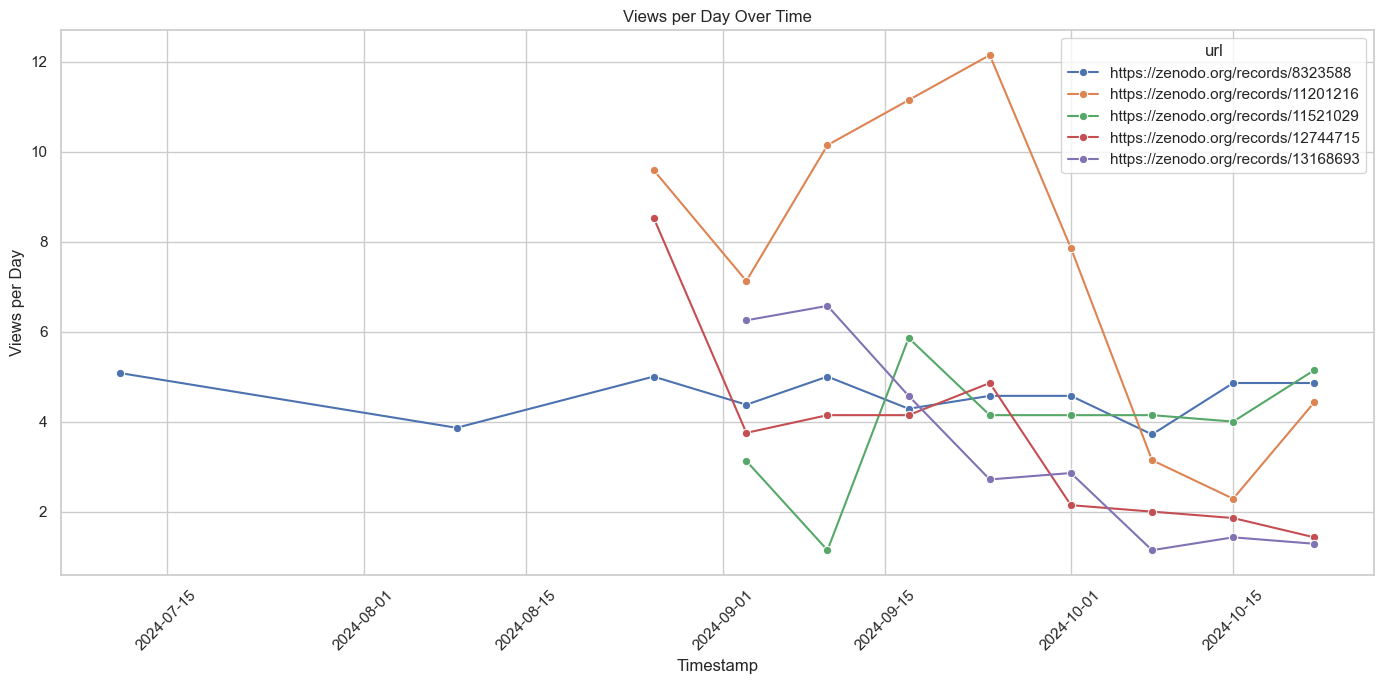

In [25]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Display only the top 5 URLs based on their views
top_labels = df.groupby('url')['views_per_day'].sum().nlargest(5).index

# Filter the DataFrame to include only the top URLs
filtered_df = df[df['url'].isin(top_labels)]

# Create the line plot
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=filtered_df, x='timestamp', y='views_per_day', hue='url', marker='o')

# Add title and labels
plt.title('Views per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Views per Day')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()

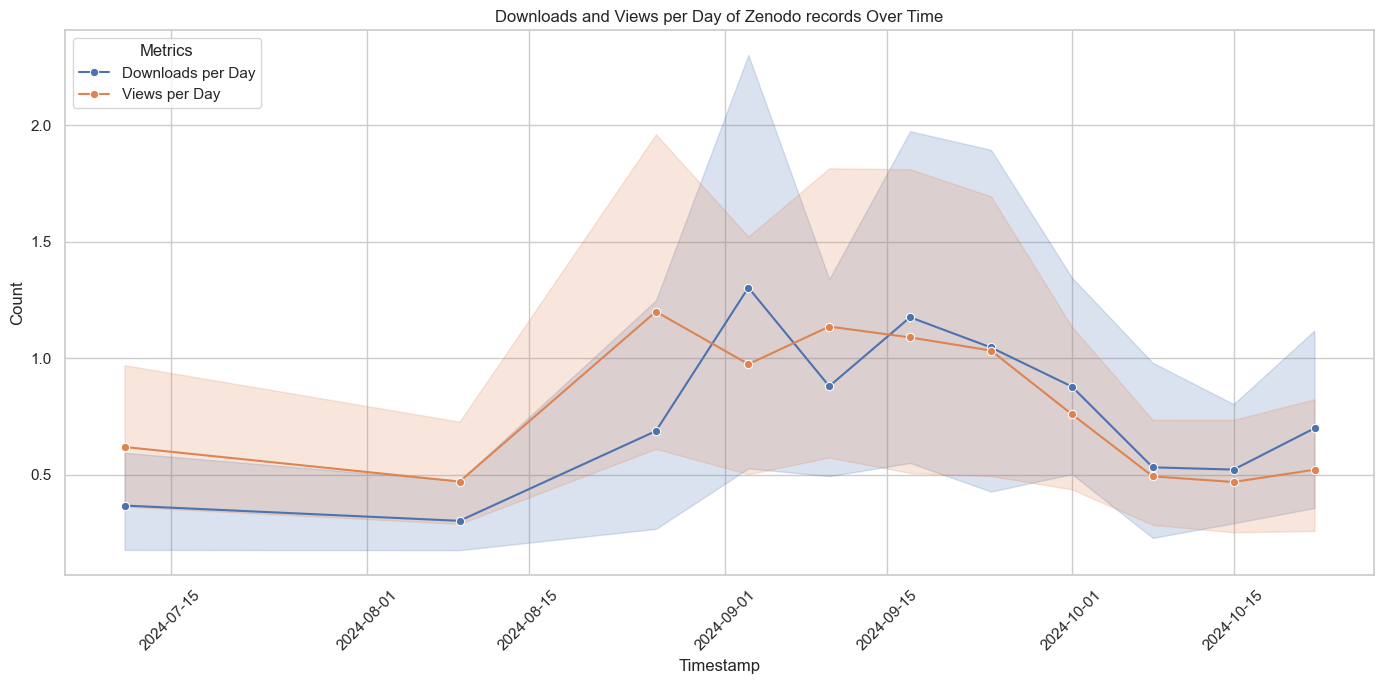

In [24]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a line plot for both 'downloads_per_day' and 'views_per_day'
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='downloads_per_day', data=df, label='Downloads per Day', marker='o')
sns.lineplot(x='timestamp', y='views_per_day', data=df, label='Views per Day', marker='o')

# Add title and labels
plt.title('Downloads and Views per Day of Zenodo records Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Add a legend to differentiate the lines
plt.legend(title='Metrics', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.savefig("../docs/statistics/downloads_and_views_over_time.png", dpi=700)
plt.show()

Three most views items last week:

In [12]:
last_week = df[df["timestamp"] == df["timestamp"].max()]
last_week = last_week.sort_values(by='views_per_day', ascending=False)
url = last_week["url"][:3]
url

4     https://zenodo.org/records/11201216
10    https://zenodo.org/records/13168693
15     https://zenodo.org/records/8323588
Name: url, dtype: object

## Viewing downloads and views for specific documents

In [13]:
df_doc = df[df["url"] == "https://zenodo.org/records/8323588"]
df_doc

,level_0,index,url,authors,downloads_per_day,views_per_day,timestamp
0,10,0,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03
7,8,7,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",4.117647,5.000000,2024-08-26
12,6,12,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",3.230769,5.076923,2024-07-11
15,7,15,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",2.428571,5.000000,2024-09-10
16,12,16,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",2.413793,3.862069,2024-08-09


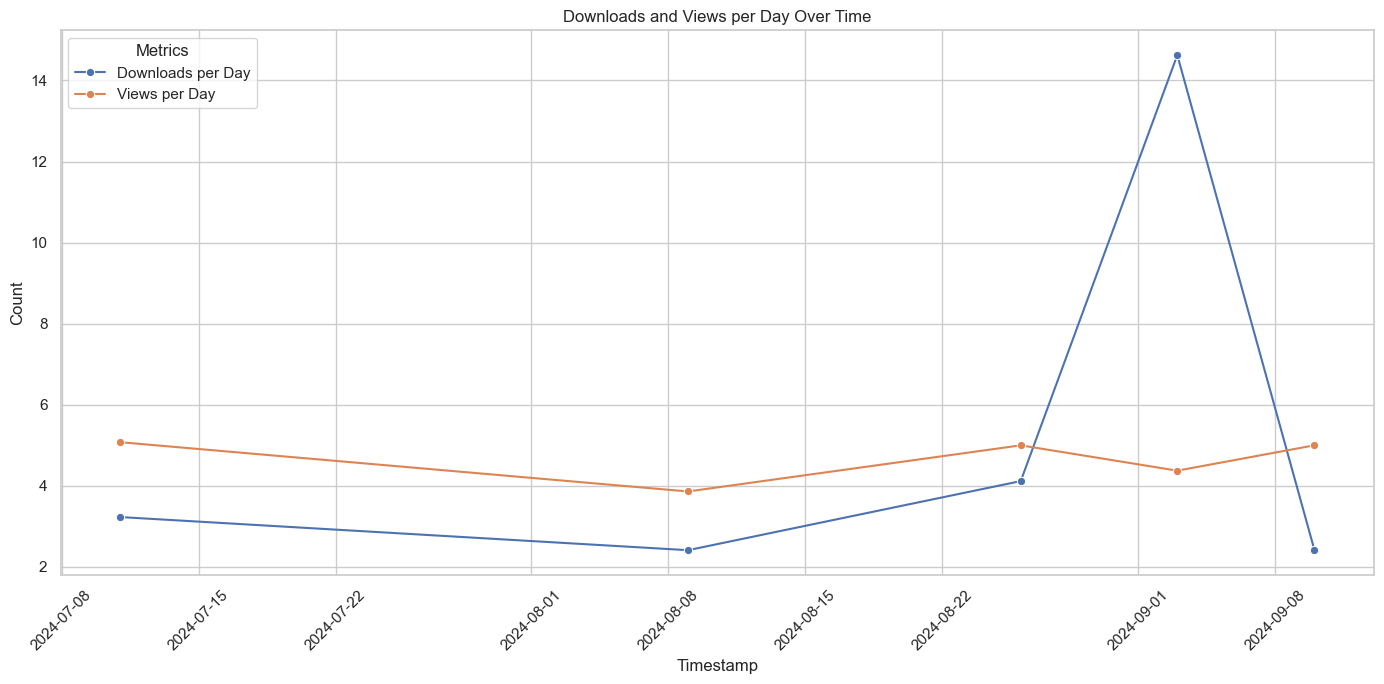

In [14]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a line plot for both 'downloads_per_day' and 'views_per_day'
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='downloads_per_day', data=df_doc, label='Downloads per Day', marker='o')
sns.lineplot(x='timestamp', y='views_per_day', data=df_doc, label='Views per Day', marker='o')

# Add title and labels
plt.title('Downloads and Views per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Add a legend to differentiate the lines
plt.legend(title='Metrics', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [15]:
import bia_bob

In [16]:
# Assuming `df` has a 'timestamp' column
#df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure timestamp is in datetime format
record_counts = df.groupby(df['timestamp'].dt.to_period('D')).size().reset_index(name='counts')
record_counts["timestamp"] = [str(d) for d in record_counts["timestamp"]]
record_counts

,timestamp,counts
0,2024-07-11,34
1,2024-08-09,34
2,2024-08-26,37
3,2024-09-03,40
4,2024-09-10,43


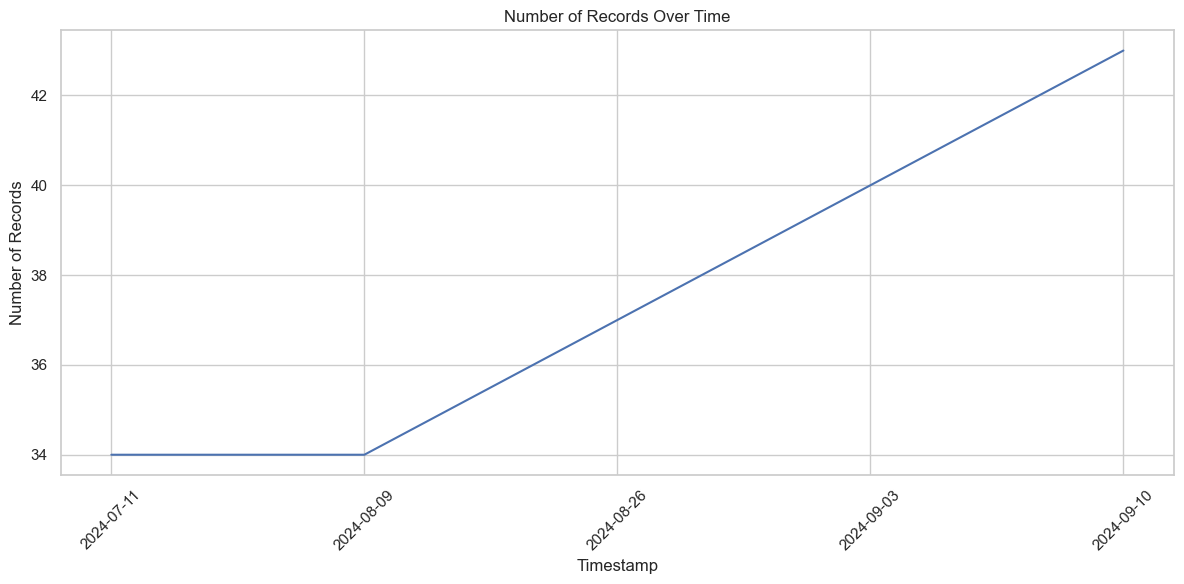

In [17]:
# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='timestamp', y='counts', data=record_counts)
plt.title('Number of Records Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()